In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#cleaning and removing dodgy images
import cv2
import imghdr

data_dir = 'data'
image_exts = ['jpeg','jpg','bmp','png']
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [4]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path) #gets the extension
            if tip not in image_exts:
                print(tip)
                print(f"Image not supported {image_path}") 
                #os.remove(image_path)
        except Exception as e:
            print(f"Issue with image {image_path}")


In [6]:
import numpy as np
from matplotlib import pyplot as plt
 #to understand any module

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data') #building data pipeline

Found 518 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator() #to create a iterator to access images batchwise

In [9]:
batch = data_iterator.next() #getting a batch

In [10]:
batch[0].shape #batch size, height, width, color_channels
#images are represented as numpy arrays

(32, 256, 256, 3)

In [11]:
batch[1] #batch{1] represents labels, batch[0] represents images as numpy arrays

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1])

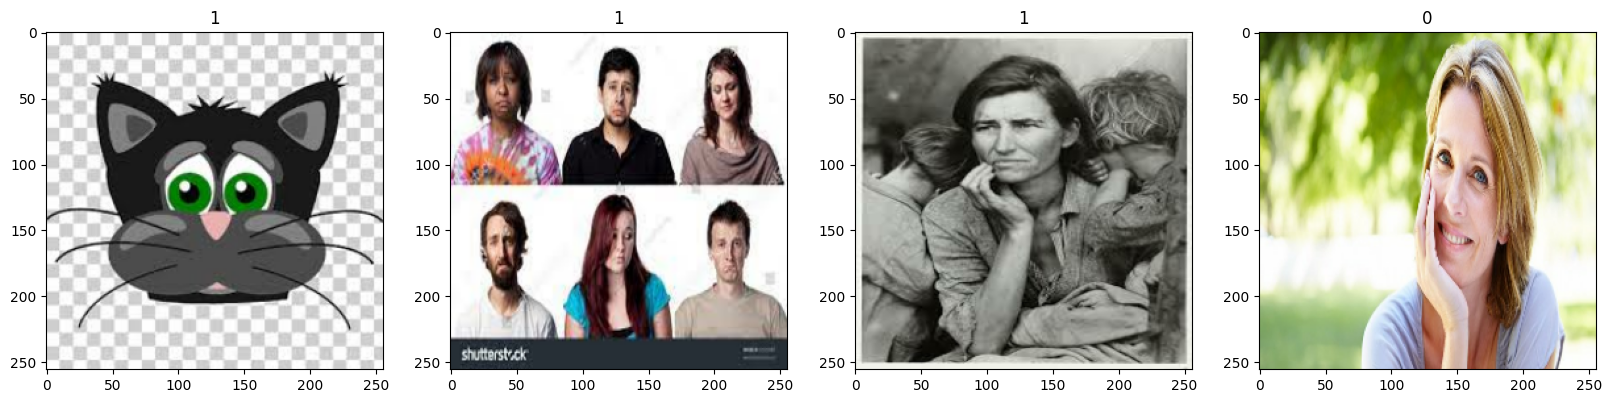

In [12]:
#to know label of 1,0 to image classes
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#class 0 = happy people, class 1 = sad people

In [13]:
#pre--processing and scaling
#since images are of 256*256, divide them by 256 so the values lies between 0 to 1. hepls processing faster
#scaled_batch = batch[0]/255
#scaled_batch.max()

data = data.map(lambda x,y: (x/255, y)) #data.map helps the trnasformation in pipeline , labels are unaltered

In [14]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()
batch[0]

array([[[[0.96148133, 0.96148133, 0.96148133],
         [0.98913145, 0.98913145, 0.98913145],
         [0.9990043 , 0.9990043 , 0.9990043 ],
         ...,
         [0.9774663 , 0.9774663 , 0.9774663 ],
         [0.9438649 , 0.9438649 , 0.9438649 ],
         [0.8991345 , 0.8991345 , 0.8991345 ]],

        [[0.9753199 , 0.9753199 , 0.9753199 ],
         [0.9956059 , 0.9956059 , 0.9956059 ],
         [0.9990043 , 0.9990043 , 0.9990043 ],
         ...,
         [0.98477113, 0.98477113, 0.98477113],
         [0.9465569 , 0.9465569 , 0.9465569 ],
         [0.8991938 , 0.8991938 , 0.8991938 ]],

        [[0.9896985 , 0.9896985 , 0.9896985 ],
         [1.        , 1.        , 1.        ],
         [0.99867946, 0.99867946, 0.99867946],
         ...,
         [0.99084556, 0.99084556, 0.99084556],
         [0.9508447 , 0.9508447 , 0.9508447 ],
         [0.9030389 , 0.9030389 , 0.9030389 ]],

        ...,

        [[0.992356  , 0.992356  , 0.992356  ],
         [1.        , 1.        , 1.        ]

In [15]:
#splitting data into train test and validation set

train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1
print(len(data))
print( train_size, val_size, test_size) #gives in number of batches

17
12 3 2


In [16]:
# using skip and take modules of tensorflow allocate data batches 
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [17]:
from tensorflow.keras.models import Sequential  #Sequential is good for one data input and one data output
                                                #funtional API is the other one, powerful and handles multiple input channels and output channels

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [18]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #16 filters/kernels of 3X3, stride=1
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu')) #32 filters/kernels of 3X3, stride=1
model.add(MaxPooling2D()) #downsampling

model.add(Conv2D(16, (3,3), 1, activation='relu')) #16 filters/kernels of 3X3, stride=1
model.add(MaxPooling2D())

model.add(Flatten()) #flatten the output coming after convolution, necessary

model.add(Dense(256, activation='relu')) #fully-connected layer with 256 hidden units. this produces 256 outputs which is input for a hidden layer
model.add(Dense(1, activation='sigmoid')) #fully-connected layer takes input from previous hidden layer and produces 1 output


C:\Users\ravik\anaconda3\envs\MyEnv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [19]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
#optimizer='adam, loss funtion = BCE loss

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#Now training
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#to store all the logs while training, how the model was during training

In [22]:
#fit the training data
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.4701 - loss: 1.7520 - val_accuracy: 0.5625 - val_loss: 0.6859
Epoch 2/20
 4/12 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.5625 - loss: 0.6797

KeyboardInterrupt: 

In [ ]:
history.history

In [ ]:
#plotting loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#if trainingloss is going down but validation loss is going up, that is an indication of overfitting, use regularization 

In [ ]:
#plotting accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Evaluating Performance

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

precision = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    ypred = model.predict(X)
    precision.update_state(y, ypred)
    recall.update_state(y, ypred)
    acc.update_state(y, ypred)

In [ ]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy: {acc.result().numpy()}')

In [ ]:
#Testing on a new image
img = cv2.imread('happytest.jpg')
plt.imshow(img)
plt.show()
img.shape

In [ ]:
#resizing it to 256X256
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy())
plt.show()

In [ ]:
#use np.expand_dims to add a dimension since our model expects a batch and not a single image
ypred = model.predict(np.expand_dims(resize/255, 0))
ypred

In [ ]:
if ypred > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
model.save(os.path.join('models', 'happysadmodel.h5'))

In [ ]:
new_model = load_model(os.path.join('models', 'happysadmodel.h5'))

In [ ]:
new= model.predict(np.expand_dims (resize/255, 0))
new